In [29]:
import torch
import torchvision.transforms as transforms
import torchvision.ops as ops
import torch.nn.functional as fn
from PIL import Image
from torch.utils.data import Dataset
import os
import math
from natsort import natsorted
import json
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import patches
import torch.optim as optim

print(torch.__version__)
batchsize = 4
imageSize = 256
gridSize = 4
numberOfClasses = 14
cellSize = imageSize/gridSize
overlap_threshold = 0.4

#Custom Dataset for the specialized task of the assignment: multi-label, multi-class object detection
class ObjectDetectionDataSet(Dataset):
    def __init__(self, root, transform):
        self.main_dir = root
        self.img_dir = os.path.join(self.main_dir, 'images')
        self.json_dir = os.path.join(self.main_dir, 'annotations')
        self.transform = transform
        all_imgs = os.listdir(self.img_dir)
        self.total_imgs = natsorted(all_imgs)
        all_json = os.listdir(self.json_dir)
        self.total_json = natsorted(all_json)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        #Image path
        img_loc = os.path.join(self.img_dir, self.total_imgs[idx])
        #Load Image
        image = Image.open(img_loc).convert("RGB")
        #Get size for resizing boxes keeping the ratio
        imageWidth , imageHeigth = image.size
        #Apply transformation (Tensorization, Resizing, Normalization) 
        image = self.transform(image)
        #Calculating aspect ratio of image
        ratio = torch.tensor([imageSize/imageWidth, imageSize/imageHeigth,imageSize/imageWidth, imageSize/imageHeigth])

        #JSON Annotation file path
        json_loc = os.path.join(self.json_dir, self.total_json[idx])
        #Open and load JSON file
        f = open(json_loc)
        jsonf = json.load(f)
        #Each file has (number of item + 2) keys, then we deduce the number of labels for the sample
        label_number = len(jsonf.keys())-2
        #The label tensor for the image is organized as follows
        # 0-3 for the bounding box coordinates (x,y,w,h)
        # 4-numberOfClasses+1 for the one-hot vector used in the classification task
        label_boxes = torch.zeros((label_number, 4))
        label_classes = torch.zeros((label_number, numberOfClasses+1))
        #Iterate through the items to populate the label tensor
        for i in range(1,label_number+1):
            #Get the bounding boxes coordinates from the annotation file
            x_min, y_min, x_max, y_max = np.multiply(jsonf['item'+str(i)]['bounding_box'],ratio)
            #Calculate the centroid position
            centroid_x, centroid_y = ((x_min+x_max)/2, (y_min+y_max)/2)
            #Calculate the height and width of the bounding box 
            bbox_w, bbox_h = ((abs(x_max-x_min)), (abs(y_max-y_min)))
            #Create a one-hot vector which is active for the class of the target
            label_classes[i-1] = fn.one_hot(torch.tensor([jsonf['item'+str(i)]['category_id']]), numberOfClasses+1)[0]
            #Put together the label vector
            label_boxes[i-1] = torch.div(torch.tensor([centroid_x,centroid_y,bbox_w,bbox_h]),imageSize)
            
        return image, label_boxes, label_classes

#We need to define a new collate function that allows us to have different length tensor for each sample in the batch.
#This is needed because samples have different amount of boxes/classes to detect
def collate_fn(batch):
    image_batch = torch.empty(batchsize,3,256,256)
    boxes_label_batch = []
    classes_label_batch = []
    i = 0
    for (image, label_boxes, label_classes) in batch:
        image_batch[i] = image
        boxes_label_batch.append(label_boxes)
        classes_label_batch.append(label_classes)
        i+=1
    return image_batch, boxes_label_batch, classes_label_batch

1.13.0+cu117


In [30]:
transformation = transforms.Compose([transforms.ToTensor(),
                                     transforms.Resize(size=(imageSize,imageSize)),
                                     transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
                                     ])
train_dataset = ObjectDetectionDataSet(root='C:/Users/pietr/Downloads/assignment_1/assignment_1/train', transform = transformation)
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batchsize,
                                          shuffle=True, num_workers=0, collate_fn = collate_fn)
test_dataset = ObjectDetectionDataSet(root='C:/Users/pietr/Downloads/assignment_1/assignment_1/test', transform = transformation)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batchsize,
                                          shuffle=False, num_workers=0, collate_fn = collate_fn)

In [31]:
#Anchor boxes are going to create our grid table of guesses for the model, in this case they are going to a 4x4 of equal sized squares
#Each anchor box is defined by its centroid, width and heigth
anchor_boxes = torch.zeros((gridSize,gridSize,4))
for i in range(0,gridSize):
  for j in range(0,gridSize):
    box = torch.tensor([j*(1/gridSize)+(1/(2*gridSize)), i*(1/gridSize)+(1/(2*gridSize)), 1/gridSize, 1/gridSize])
    anchor_boxes[i,j] = box
anchor_boxes = anchor_boxes.repeat(batchsize,1,1,1)

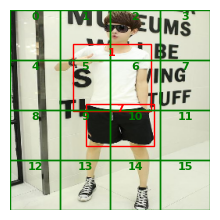

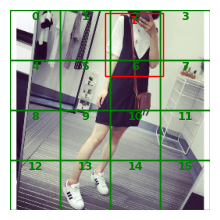

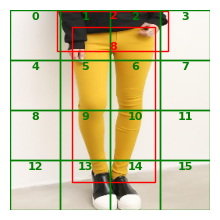

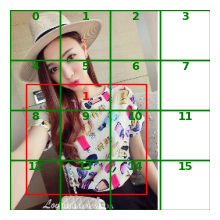

In [32]:
dataiter = iter(trainloader)
images, label_boxes, label_classes= next(dataiter)
for image, label_boxes, label_classes in zip(images, label_boxes,label_classes):
  
  img_unnorm = image/2+0.5
  img_transp = np.transpose(img_unnorm, [1,2,0])
  fig = plt.figure(figsize=(2,2))
  ax = fig.add_axes([0,0,1,1])
  plt.imshow(img_transp)
  for i,(boxes,classes) in enumerate(zip(label_boxes,label_classes)):
    xmin, ymin, w, h = boxes*imageSize
    box = patches.Rectangle((xmin-w/2, ymin-h/2), w, h, edgecolor = "red", facecolor = "none")
    ax.add_patch(box)
    rx, ry = box.get_xy()
    cx = rx+box.get_width()/2.0
    cy = ry+box.get_height()/8.0
    class_id = torch.argmax(classes).item()
    l = ax.annotate(
        class_id,
        (cx, cy),
        fontsize = 8,
        fontweight = "bold",
        color = "red",
        ha = 'center',
        va = 'center'
    )
  for i,row in enumerate(anchor_boxes[0]):
    for j, col in enumerate(row):
      xmin, ymin, w, h = (col*imageSize)
      box = patches.Rectangle((xmin-w/2, ymin-h/2), w, h, edgecolor = "green", facecolor = "none")
      ax.add_patch(box)
      rx, ry = box.get_xy()
      cx = rx+box.get_width()/2.0
      cy = ry+box.get_height()/8.0
      class_id = f"{i*gridSize+j}"
      l = ax.annotate(
          class_id,
          (cx, cy),
          fontsize = 8,
          fontweight = "bold",
          color = "green",
          ha = 'center',
          va = 'center'
      )
  plt.axis('off')

In [33]:
import torch.nn as nn
device = torch.device("cuda")

class OutputLayer(nn.Module):
    def __init__(self,nin):
        super().__init__()
        self.output_conv1 = nn.Conv2d(nin, (numberOfClasses+1),kernel_size=3, padding="same")
        self.output_conv2 = nn.Conv2d(nin, 4, kernel_size =3, padding="same")
    def forward(self, x):
        return torch.cat((self.output_conv1(x), self.output_conv2(x)), dim=1)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 6, kernel_size = 5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride = 2),
            OutputLayer(128)
        )

    def forward(self, x):
      return self.model(x)

net = Net()

In [34]:
#Both parameters have shape (batchSize, gridSize, gridSize, 4)
def activation_to_bb_prediction(batch_boxes_activations, anchor_boxes):
  #The activation value of the boxes is interpreted as the stretch in the centroid coordinates, width and height of the anchor box.
  activated_boxes = torch.tanh(batch_boxes_activations)
  boxes_centroid_coordinates = (activated_boxes[:,:,:,:2]/2 *gridSize)*anchor_boxes[:,:,:,:2]
  boxes_width_height = (activated_boxes[:,:,:,2:]/2+1)*anchor_boxes[:,:,:,2:]
  result = torch.cat((boxes_centroid_coordinates,boxes_width_height), dim=3)
  return result


In [35]:
#batch_hw_boxes has shape (batchSize, gridSize, gridSize, 4)
def batch_hw_to_corners(batch_hw_boxes):
    corners_boxes_x1 = torch.unsqueeze(batch_hw_boxes[:,:,:,0]-torch.div(batch_hw_boxes[:,:,:,2],2),3)
    corners_boxes_y1 = torch.unsqueeze(batch_hw_boxes[:,:,:,1]-torch.div(batch_hw_boxes[:,:,:,3],2),3)
    corners_boxes_x2 = torch.unsqueeze(batch_hw_boxes[:,:,:,0]+torch.div(batch_hw_boxes[:,:,:,2],2),3)
    corners_boxes_y2 = torch.unsqueeze(batch_hw_boxes[:,:,:,1]+torch.div(batch_hw_boxes[:,:,:,3],2),3)
    return torch.cat((corners_boxes_x1,corners_boxes_y1, corners_boxes_x2, corners_boxes_y2), dim=3)

#predicted_boxes has shape (gridSize, gridSize, 4), target_boxes is list of length label_number, each item is then a 4 tensor
def get_iou_torch(predicted_boxes, target_boxes):
    target_x1 = torch.unsqueeze(target_boxes[:,0]-target_boxes[:,2]/2,1)
    target_y1 = torch.unsqueeze(target_boxes[:,1]-target_boxes[:,3]/2,1)
    target_x2 = torch.unsqueeze(target_boxes[:,0]+target_boxes[:,2]/2,1)
    target_y2 = torch.unsqueeze(target_boxes[:,1]+target_boxes[:,3]/2,1)
    #target_box_corners has size (labelNumber, 4)
    target_box_corners = torch.cat((target_x1,target_y1, target_x2, target_y2), dim=1).repeat(gridSize,gridSize,1,1).to(device)
    temp = torch.unsqueeze(predicted_boxes, dim=2).repeat(1,1,len(target_boxes),1)
    intersections_dx = torch.min(temp[:,:,:,2], target_box_corners[:,:,:,2]) - torch.max(temp[:,:,:,0], target_box_corners[:,:,:,0])
    intersections_dy = torch.min(temp[:,:,:,3], target_box_corners[:,:,:,3]) - torch.max(temp[:,:,:,1], target_box_corners[:,:,:,1])
    intersections_x_contribute= torch.max(torch.tensor(0), intersections_dx)
    intersections_y_contribute= torch.max(torch.tensor(0), intersections_dy)
    intersections_areas = intersections_x_contribute * intersections_y_contribute
    predicted_boxes_areas = (temp[:,:,:,2]-temp[:,:,:,0])*(temp[:,:,:,3]-temp[:,:,:,1])
    target_boxes_areas = (target_box_corners[:,:,:,2]-target_box_corners[:,:,:,0])*(target_box_corners[:,:,:,3]-target_box_corners[:,:,:,1])
    union_boxes_areas = predicted_boxes_areas+target_boxes_areas - intersections_areas
    overlap = intersections_areas/union_boxes_areas
    return overlap
    
    

In [36]:
def map_to_gt(overlaps):
    prior_overlap, prior_index = overlaps.max(1)
    gt_overlap, gt_index = overlaps.max(0)
    
    gt_overlap[prior_index]=1.99
    for i,o in enumerate(prior_index): gt_index[o]=i
    return gt_overlap, gt_index

class_loss_fn = torch.nn.BCEWithLogitsLoss()

def ssd_singleImage_loss(pred_classes, pred_boxes, target_classes, target_boxes):
    
    pred_classes = pred_classes[:,:-1]
    overlaps= get_iou_torch(pred_boxes, target_boxes)
    overlaps = overlaps.flatten(start_dim=0,end_dim=1).permute(1,0)
    pred_boxes = pred_boxes.flatten(start_dim=0,end_dim=1).permute(0,1)
    gt_overlap, gt_index = map_to_gt(overlaps)
    target_class_ids = torch.argmax(target_classes, dim=1).to(device)
    positive_match = gt_overlap>overlap_threshold
    
    positive_index = torch.nonzero(positive_match)[:,0]
    gt_class = target_class_ids[gt_index]
    gt_class[~positive_match] = 14
    gt_boxes = target_boxes[gt_index]
    loc_loss = ((pred_boxes[positive_index] - gt_boxes[positive_index]).abs()).mean()
    gt_class = torch.eye(numberOfClasses+1)[gt_class.cpu()]
    gt_class = gt_class[:,:-1].to(device)
    class_loss = class_loss_fn(pred_classes.float(), gt_class.float())
    return loc_loss, class_loss

def ssd_loss(pred_classes, pred_boxes, target_classes, target_boxes):
    localization_loss = 0.
    classification_loss = 0.
    for pred_item_classes, pred_item_boxes, target_item_classes, target_item_boxes in zip(pred_classes, pred_boxes, target_classes, target_boxes):
        target_item_boxes = target_item_boxes.to(device)
        target_item_classes = target_item_classes.to(device)
        loc_loss, class_loss = ssd_singleImage_loss(pred_item_classes, pred_item_boxes, target_item_classes, target_item_boxes)
        localization_loss += loc_loss
        classification_loss += class_loss
    return localization_loss+classification_loss

In [37]:

optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=0.01)

net = net.to(device)
anchor_boxes = anchor_boxes.to(device)
criterion = ssd_loss
loss_history = []

for epoch in range(3):
  running_loss = 0.0
  for i,batch in enumerate(trainloader):
    batch_images, batch_boxes, batch_classes = batch
    batch_images = batch_images.to(device)
    optimizer.zero_grad()
    output = net(batch_images)
    output = output.permute(0,2,3,1)
    
    pred_box = output[:,:,:,:4]
    pred_box = activation_to_bb_prediction(pred_box,anchor_boxes)
    pred_box = batch_hw_to_corners(pred_box)

    pred_class = output[:,:,:,4:]
    pred_class = pred_class.flatten(start_dim =1, end_dim = 2)

    loss = criterion(pred_class, pred_box, batch_classes, batch_boxes)
    loss.backward()
    optimizer.step()
    loss_history.append(loss.item())
    running_loss +=loss.item()
    if i % 250 == 249:  # Printing the runnin loss every 500 mini-batches
      print(f"[epoch: {epoch + 1}, mini-batch: {i + 1}] loss: {(running_loss / 250):.3f}")
      running_loss = 0.0
    
    
print('Finished Training')
  

KeyboardInterrupt: 

In [ ]:
dataiter = iter(testloader)
batch_images,batch_boxes, batch_classes  = next(dataiter)
images = images.to(device)
outputs = net(images)
output = output.permute(0,2,3,1)
pred_box = output[:,:,:,:4].detach().cpu()
pred_class = output[:,:,:,4:].detach().cpu()
print(pred_class.shape)
pred_class = torch.max(pred_class, dim=3)

for i, (img, item_classes, item_boxes) in enumerate(zip(batch_images, batch_classes, batch_boxes)):
  img_unnorm = img/2+0.5
  img_transp = np.transpose(img_unnorm, [1,2,0])
  fig = plt.figure(figsize=(2,2))
  ax = fig.add_axes([0,0,1,1])
  plt.imshow(img_transp)
  for i,(box,classes) in enumerate(zip(item_boxes,item_boxes)):
    xmin, ymin, w, h = box*imageSize
    box = patches.Rectangle((xmin-w/2, ymin-h/2), w, h, edgecolor = "red", facecolor = "none")
    ax.add_patch(box)
    rx, ry = box.get_xy()
    cx = rx+box.get_width()/2.0
    cy = ry+box.get_height()/8.0
    class_id = torch.argmax(classes).item()
    l = ax.annotate(
        class_id,
        (cx, cy),
        fontsize = 8,
        fontweight = "bold",
        color = "red",
        ha = 'center',
        va = 'center'
    )
  for k,row in enumerate(pred_box[i]):
    for j, col in enumerate(row):
      print(col)
      xmin, ymin, w, h = (col*imageSize)
      box = patches.Rectangle((xmin-w/2, ymin-h/2), w, h, edgecolor = "green", facecolor = "none")
      ax.add_patch(box)
      rx, ry = box.get_xy()
      cx = rx+box.get_width()/2.0
      cy = ry+box.get_height()/8.0
      class_id = f"{pred_class[i,k,j]}"
      l = ax.annotate(
          class_id,
          (cx, cy),
          fontsize = 8,
          fontweight = "bold",
          color = "green",
          ha = 'center',
          va = 'center'
      )
  plt.axis('off')

IndexError: max(): Expected reduction dim 3 to have non-zero size.